TP 3 : Plongements lexicaux et réécriture de textes
====

1 - Introduction
------

Dans ce TP, nous aborderons les plongements lexicaux à travers la bibliothèque Gensim et nous verrons comment réécrire des textes dans le cadre du projet d'écriture créative OULIPO (https://fr.wikipedia.org/wiki/Oulipo).

N'hésitez pas à regarder régulièrement la documentation des librairies, des exemples d\'utilisation accompagnent généralement l\'explication de chaque fonction.

- Gensim : https://radimrehurek.com/gensim/apiref.html
- Scikit-learn : https://scikit-learn.org/stable/


Installation des librairies si nécessaire.

In [1]:
!pip install --upgrade gensim
!pip install --upgrade scikit-learn

Import des librairies.

In [2]:
import gensim
from gensim import corpora
import gensim.downloader as api
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
from nltk.corpus import stopwords
import nltk
from pprint import pprint

Charger un modèle du langage. Attention les modèles peuvent être assez lourds et leur chargement peut prendre un certain temps. Tous les modèles sont accessibles [ICI](https://github.com/RaRe-Technologies/gensim-data).

In [3]:
# pour GloVe
wv = api.load('glove-wiki-gigaword-300')

# pour FastText
# wv = api.load('fasttext-wiki-news-subwords-300')

# pour ConceptNet Numberbatch
# wv = api.load('conceptnet-numberbatch-17-06-300')

# pour Word2vec
# wv = api.load('word2vec-google-news-300')

In [4]:
wv

2 - Analyser les plongements lexicaux
------

Identifier la taille du plongement. Le nombre de lignes correspond au nombre de mots répertoriés dans le plogement et le nombre de colonnnes correspond au nombre de dimensions latentes de la représentation vectorielle.

In [5]:
wv.vectors.shape

(400000, 300)

Accéder au vecteur d'un mot donné.

In [6]:
wv['cat'].shape

(300,)

Calculer la similarité cosinus entre deux mots à partir des représentations vectorielles.

In [7]:
from numpy.linalg import norm
def cosine_similarity(A, B):
    return np.dot(A,B)/(norm(A)*norm(B))
cosine_similarity(wv['cat'], wv['dog'])

0.6816746

[Q1] Définir la distance euclidienne entre deux mots à partir des représentations vectorielles.

In [8]:
# Représentations vectorielles des mots "cat" et "dog"
A = wv['cat']
B = wv['dog']

# Calculer la différence entre les vecteurs
C = A - B

# Calculer la distance euclidienne
distance_euclidienne = norm(C)

print(f"Distance euclidienne entre 'cat' et 'dog': {distance_euclidienne}")


Distance euclidienne entre 'cat' et 'dog': 5.195904731750488


In [9]:
# insérer votre code ici

[Q2] Trouver la méthode qui implémente le cosinus dans Gensim, et montrer les résultats pour les paires de mots suivantes: (football, soccer), (football, elephant), (good, bad), (black, white), (yesterday,tomorrow). Quelles sont vos remarques?

In [10]:
# Paires de mots
word_pairs = [("football", "soccer"), ("football", "elephant"), ("good", "bad"),
              ("black", "white"), ("yesterday", "tomorrow")]

# Calculer la similarité cosinus pour chaque paire de mots
similarities = [(pair, wv.similarity(pair[0], pair[1])) for pair in word_pairs]

# Afficher les résultats
for pair, similarity_score in similarities:
    print(f"Similarité cosinus entre '{pair[0]}' et '{pair[1]}': {similarity_score}")

Similarité cosinus entre 'football' et 'soccer': 0.7682591676712036
Similarité cosinus entre 'football' et 'elephant': 0.014457962475717068
Similarité cosinus entre 'good' et 'bad': 0.644521951675415
Similarité cosinus entre 'black' et 'white': 0.7135820984840393
Similarité cosinus entre 'yesterday' et 'tomorrow': 0.5682692527770996


In [11]:
# insérer votre code ici

[Q3] Comment relier la fonction wv.distance() à la fonction wv.similarity()?

In [12]:
def is_similar_enough(word1, word2, threshold=0.5):
    # Calculer la similarité cosinus entre les mots
    similarity_score = wv.similarity(word1, word2)

    # Vérifier si la similarité dépasse le seuil donné
    return similarity_score >= threshold

# Mots à comparer
word1 = "cat"
word2 = "dog"

# Vérifier la similarité entre les mots
result = is_similar_enough(word1, word2)

# Afficher le résultat
print(f"Les mots '{word1}' et '{word2}' sont similaires : {result}")

Les mots 'cat' et 'dog' sont similaires : True


In [13]:
# insérer votre code ici

Trouver les K plus proches voisins d'un mot dans le plongement lexical.

In [14]:
K=5
wv.most_similar(positive=['cup'], topn=K)

[('cups', 0.6957379579544067),
 ('champions', 0.6520988941192627),
 ('finals', 0.6479452848434448),
 ('tournament', 0.6046193838119507),
 ('championship', 0.6013892292976379)]

[Q4] Ecrire la fonction qui calcule les K plus proches voisins d'un mot de référence sans recourir à la méthode wv.most_similar(). Vous devrez calculer le cosinus du mot de référence avec tous les mots du modèle qui se trouvent dans wv.vectors.

In [15]:
from sklearn.metrics.pairwise import cosine_similarity

def find_nearest_neighbors_sklearn(word, K, wv):
    # Obtenir le vecteur du mot de référence
    ref_vector = wv.get_vector(word).reshape(1, -1)

    # Obtenir les vecteurs de tous les mots
    all_vectors = [wv.get_vector(w) for w in wv.index_to_key]
    all_vectors = np.array(all_vectors)

    # Calculer la similarité cosinus entre le vecteur de référence et tous les vecteurs
    similarities = cosine_similarity(ref_vector, all_vectors).flatten()

    # Trier les indices des mots en fonction de la similarité cosinus
    indices_sorted = similarities.argsort()[::-1]

    # Sélectionner les K mots les plus proches (en excluant le mot de référence lui-même)
    nearest_neighbors = [(wv.index_to_key[i], similarities[i]) for i in indices_sorted[1:K+1]]

    return nearest_neighbors

# Utilisation de la fonction pour trouver les 5 plus proches voisins du mot "cup"
word = "cat"
K = 5
nearest_neighbors = find_nearest_neighbors_sklearn(word, K, wv)

# Afficher les résultats
for neighbor, similarity in nearest_neighbors:
    print(f"Mot: {neighbor}, Similarité: {similarity}")


Mot: dog, Similarité: 0.6816746592521667
Mot: cats, Similarité: 0.6815836429595947
Mot: pet, Similarité: 0.5870366096496582
Mot: dogs, Similarité: 0.540766716003418
Mot: feline, Similarité: 0.48979711532592773


In [16]:
# insérer votre code ici
from sklearn.metrics.pairwise import cosine_similarity

Trouver l'inconnu. Etant donnée une liste de mots, la méthode wv.doesnt_match() trouve le mot le moins similaire à tous les autres dans la liste.

In [17]:
wv.doesnt_match(['cat', 'dog', 'mouse', 'airplane', 'bird', 'turtle'])

'airplane'

3 - Comprendre l'analogie dans les plongements lexicaux
------

La particularité des plongements lexicaux est leur régularité. Il est donc possible d'exprimer des relations lexicales à partir d'opérations sur les vecteurs. Par exemple, la relation entre man et king est la même que celle entre woman et queen, qui peut être exprimée de la façon suivante: man - king = woman - queen. Ainsi, il suffit de remplacer un des mots par une variable pour comprendre la capacité du modèle à encoder la sémantique lexicale: i.e., x = king - man + woman.

In [18]:
wv.most_similar(positive=['woman', 'king'], negative=['man'])

[('queen', 0.6713277101516724),
 ('princess', 0.5432624816894531),
 ('throne', 0.5386103987693787),
 ('monarch', 0.5347574949264526),
 ('daughter', 0.49802514910697937),
 ('mother', 0.49564430117607117),
 ('elizabeth', 0.4832652509212494),
 ('kingdom', 0.47747090458869934),
 ('prince', 0.4668239951133728),
 ('wife', 0.46473270654678345)]

[Q5] Tester plusieurs analogies pour trouver la capitale de la Bulgarie, la marque de luxe de Nissan et le prétérite du verbe carry.

In [19]:
from gensim.models import KeyedVectors

def find_analogy(model, positive, negative):
    result = model.most_similar(positive=positive, negative=negative)
    return result[0][0] if result else None

# 1. Capitale de la Bulgarie
capital = find_analogy(wv, ['bulgaria', 'capitale'], ['sofia'])
print(f"Capitale de la Bulgarie: {capital}")

# 2. Marque de luxe de Nissan
luxury_brand = find_analogy(wv, ['nissan', 'luxe'], ['infiniti'])
print(f"Marque de luxe de Nissan: {luxury_brand}")

# 3. Prétérite du verbe "carry"
past_tense = find_analogy(wv, ['carry', 'past'], ['carried'])
print(f"Prétérite du verbe 'carry': {past_tense}")




Capitale de la Bulgarie: bénin
Marque de luxe de Nissan: mitsubishi
Prétérite du verbe 'carry': come


In [20]:
print(wv)

KeyedVectors<vector_size=300, 400000 keys>


In [21]:
# insérer votre code ici

3 - Analyser les biais dans les plongements lexicaux
------

Étant donné que les plongements lexicaux sont formés à partir de textes produits par des humains, ils présentent inévitablement certains biais propres à la population humaine en général. Un exemple est le biais de genre dans le domaine professionnel. Par exemple, les plongements montrent que certaines professions sont considérées comme étant principalement masculines ou féminines. Les autres préjugés que peuvent avoir les plongements sont liés à la race, la nationalité, l'âge, la religion, etc. Ainsi, lorsque vous construisez vos applications en TAL, vous devez toujours prendre en compte le biais que les plongements contiennent car ceux-ci seront également transférés dans votre modèle.


Trouver le penchant féminin de doctor.

In [22]:
pprint(wv.most_similar_cosmul(positive=['she', 'doctor'], negative=['he']))

[('nurse', 0.9194773435592651),
 ('woman', 0.8524463772773743),
 ('her', 0.8486989736557007),
 ('mother', 0.8447303771972656),
 ('pregnant', 0.8356964588165283),
 ('doctors', 0.8306604027748108),
 ('dentist', 0.8206111192703247),
 ('sister', 0.8120761513710022),
 ('physician', 0.810595691204071),
 ('nurses', 0.8073124289512634)]


[Q6] Comment pourriez-vous définir de façon différente la genrification des professions? Les résultats seraient-ils différents?

In [23]:
from gensim.models import KeyedVectors
from pprint import pprint

# Recherche des mots associés à "doctor" en supprimant le genre
result1 = wv.most_similar_cosmul(positive=['woman','doctor'], negative=[ 'man'])
print("Résultat 1:")
pprint(result1)

# Recherche des mots associés à "doctor" en supprimant le genre et le genre biologique
result2 = wv.most_similar_cosmul(positive=['man','doctor'], negative=['woman'])
print("Résultat 2:")
pprint(result2)


Résultat 1:
[('nurse', 0.9290759563446045),
 ('physician', 0.9234048128128052),
 ('doctors', 0.9137150645256042),
 ('pregnant', 0.8704767823219299),
 ('dentist', 0.8677983283996582),
 ('pediatrician', 0.8657986521720886),
 ('physicians', 0.863629162311554),
 ('nurses', 0.8633697628974915),
 ('pharmacist', 0.857897937297821),
 ('medical', 0.8489453792572021)]
Résultat 2:
[('dr.', 0.7992066740989685),
 ('mr.', 0.7960942387580872),
 ('brother', 0.7936785817146301),
 ('he', 0.7912783622741699),
 ('physician', 0.7861927151679993),
 ('himself', 0.7712264060974121),
 ('his', 0.7685517072677612),
 ('him', 0.7677589654922485),
 ('uncle', 0.7625024318695068),
 ('father', 0.7592216730117798)]


In [24]:
# Insérez votre code ici

3 - Visualisation des plongements lexicaux
------

Il existe plusieurs méthodes de visualisation des données en N dimensions. Elles permettent de réduire la dimensionnalité de l'espace pour la rendre visible dans une espace à 2 ou à 3 dimensions. L'une de ces méthodes est la [t-SNE](https://distill.pub/2016/misread-tsne/).

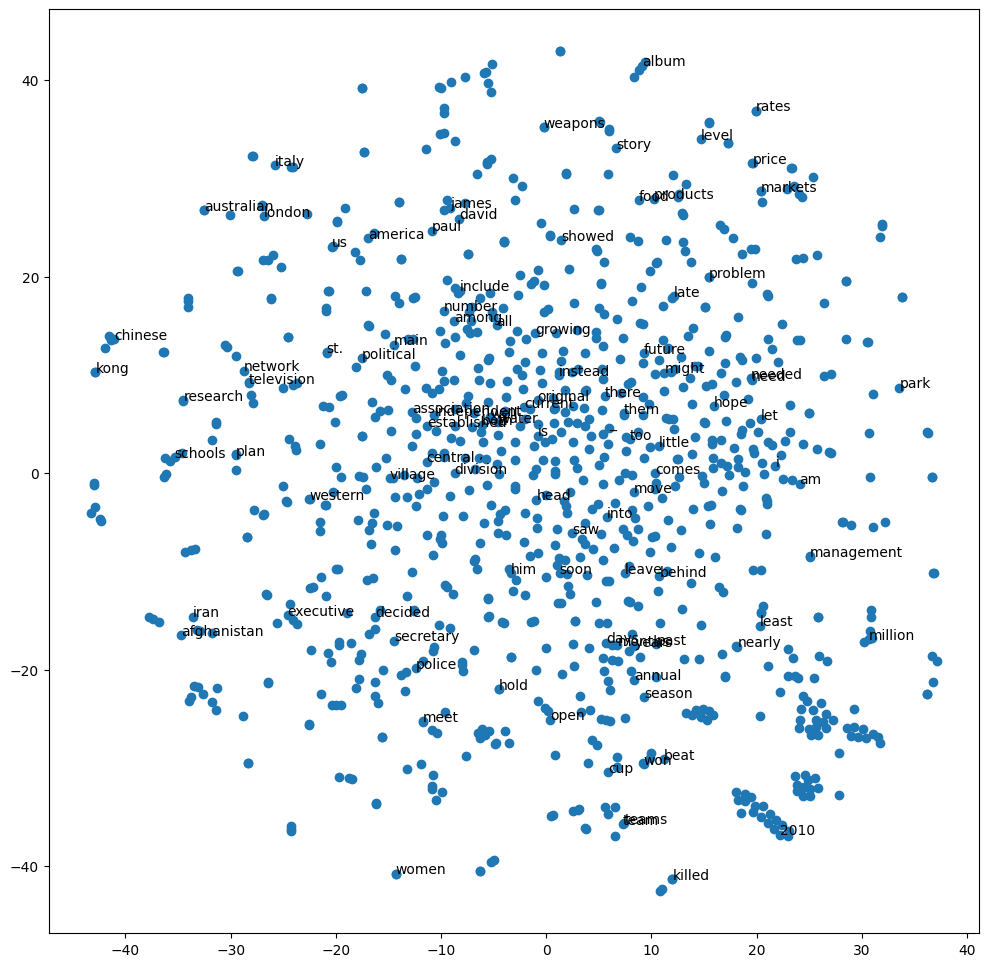

In [25]:
import matplotlib.pyplot as plt
import random

def reduce_dimensions(wv, n):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(wv.vectors[:n])
    labels = np.asarray(wv.index_to_key[:n])

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, learning_rate='auto', init='random')
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

def plot_with_matplotlib(x_vals, y_vals, labels):
    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    # Label randomly subsampled 100 data points
    random.seed(0)
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 100)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

x_vals, y_vals, labels = reduce_dimensions(wv, 1000)
plot_with_matplotlib(x_vals, y_vals, labels)

[Q7] Implémenter la visualisation grâce à la méthode [MDS](https://andrewirwin.github.io/data-visualization/mds.html), puis avec la méthode [PCA](https://andrewirwin.github.io/data-visualization/pca.html). Quelles sont vos remarques entre les trois visualisations?

In [26]:
# Methode- MDS
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import random

def perform_mds_dimensionality_reduction(word_vectors, num_vectors_to_analyze):
  
    target_dimensions = 2  

    vectors_subset = np.array(word_vectors.vectors[:num_vectors_to_analyze])
    words_subset = np.array(word_vectors.index_to_key[:num_vectors_to_analyze])

    mds_model = MDS(n_components=target_dimensions, dissimilarity='euclidean', random_state=42)
    reduced_vectors = mds_model.fit_transform(vectors_subset)
    
    x_coordinates, y_coordinates = reduced_vectors[:, 0], reduced_vectors[:, 1]
    
    return x_coordinates, y_coordinates, words_subset


In [27]:
def plot_with_matplotlib_mds(x_vals, y_vals, labels):
    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    # Label randomly subsampled 100 data points
    random.seed(0)
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 100)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

    plt.title('MDS Visualization of Word Embeddings')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

c:\Users\Ismael\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


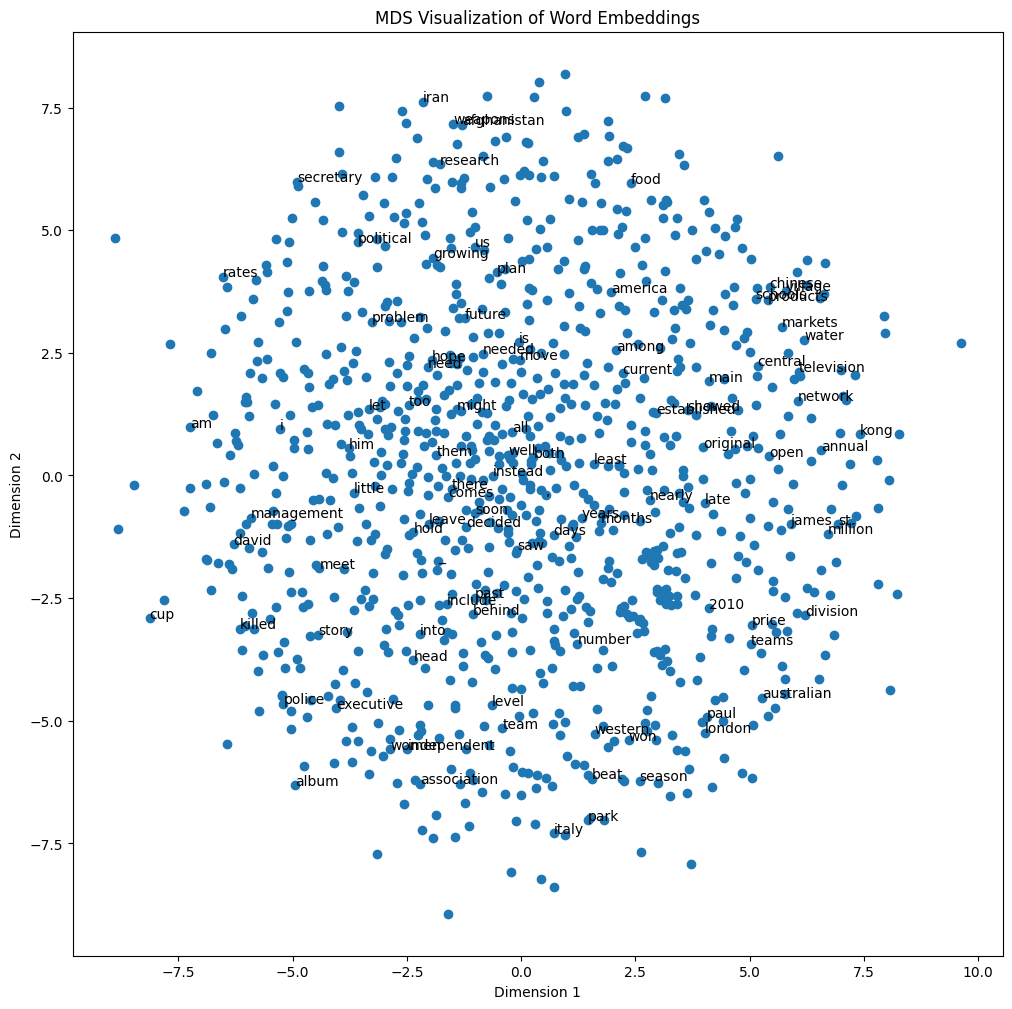

In [28]:
x_vals, y_vals, labels = perform_mds_dimensionality_reduction(wv, 1000)
plot_with_matplotlib_mds(x_vals, y_vals, labels)

In [29]:
# Methode - PCA
def perform_pca_dimensionality_reduction(embeddings, number_of_vectors):
    # The desired number of dimensions to reduce to is set to 2 for a 2D plot.
    target_dimensionality = 2

    # Retrieve the first 'number_of_vectors' word vectors and their labels.
    vector_subset = np.array(embeddings.vectors[:number_of_vectors])
    label_subset = np.array(embeddings.index_to_key[:number_of_vectors])

    # Initialize the PCA model and apply it to reduce the word vectors.
    pca_model = PCA(n_components=target_dimensionality)
    reduced_vectors = pca_model.fit_transform(vector_subset)

    # Split the reduced vectors into their respective x and y components.
    x_coordinates = reduced_vectors[:, 0]  # All x values
    y_coordinates = reduced_vectors[:, 1]  # All y values

    return x_coordinates, y_coordinates, label_subset


In [30]:
def plot_with_matplotlib_pca(x_vals, y_vals, labels):
    plt.figure(figsize=(15, 15))
    plt.scatter(x_vals, y_vals)
    random.seed(0)
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 100)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))
    plt.title('PCA Visualization of Word Embeddings')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()




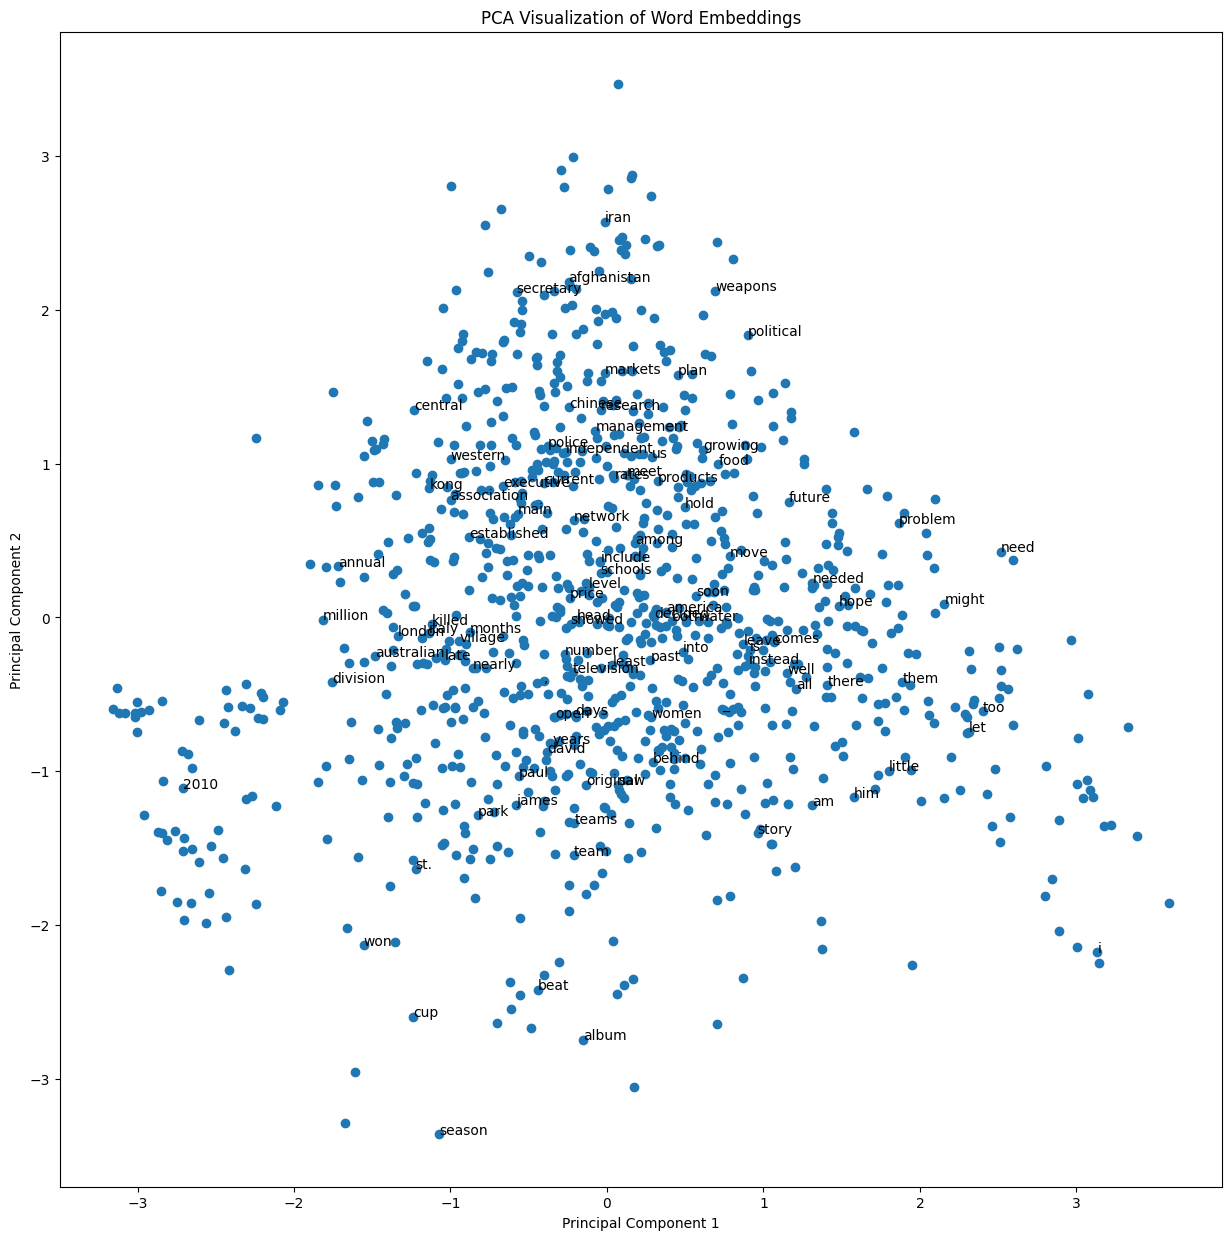

In [31]:
x_vals, y_vals, labels = perform_pca_dimensionality_reduction(wv, 1000)
plot_with_matplotlib_pca(x_vals, y_vals, labels)

4 - PROJET : Réécrire un texte à partir de tranformations basées sur les plongements lexicaux
------

[Projet Q1] Réécrire un texte donné en anglais de sorte à ce que chaque substantif du texte soit remplacé par le Kème mot le plus proche dans le plongement lexical. Vous générerez le nuage de mots correspondant à partir du texte réécrit.

In [32]:
!python -m spacy download en_core_web_lg

     ---------------------------------------- 0.0/587.7 MB ? eta -:--:--
     ---------------------------------------- 0.1/587.7 MB ? eta -:--:--
     ---------------------------------------- 0.2/587.7 MB 2.5 MB/s eta 0:03:59
     ---------------------------------------- 0.3/587.7 MB 2.0 MB/s eta 0:05:00
     ---------------------------------------- 0.5/587.7 MB 2.3 MB/s eta 0:04:11
     ---------------------------------------- 0.7/587.7 MB 3.1 MB/s eta 0:03:08
     ---------------------------------------- 1.0/587.7 MB 3.5 MB/s eta 0:02:49
     ---------------------------------------- 1.2/587.7 MB 3.6 MB/s eta 0:02:44
     ---------------------------------------- 1.5/587.7 MB 3.9 MB/s eta 0:02:31
     ---------------------------------------- 1.7/587.7 MB 3.9 MB/s eta 0:02:31
     ---------------------------------------- 2.2/587.7 MB 4.4 MB/s eta 0:02:13
     ---------------------------------------- 2.4/587.7 MB 4.6 MB/s eta 0:02:09
     ---------------------------------------- 2.8/587.

In [33]:
!pip install wordcloud

In [34]:
# insérer votre code ici
# Fonction pour trouver le Kème mot le plus proche
def find_kth_closest_word(word, rank=1):
    try:
        return wv.most_similar(word, topn=rank)[rank-1][0]
    except KeyError:
        return word

# Texte original
texte_original = """
Gender stereotype theory suggests that men are generally perceived as more masculine than women, whereas women are generally perceived as more feminine than men. Several scales have been developed to measure fundamental aspects of gender stereotypes (e.g., agency and communion, competence and warmth, or instrumentality and expressivity). Although omitted in later versions, Bem's original Sex Role Inventory included the items “masculine” and “feminine” in addition to more specific gender-stereotypical attributes. We argue that it is useful to be able to measure these two core concepts in a reliable, valid, and parsimonious way. We introduce a new and brief scale, the Traditional Masculinity-Femininity (TMF) scale, designed to assess central facets of self-ascribed masculinity-femininity. Studies 1–2 used known-groups approaches (participants differing in gender and sexual orientation) to validate the scale and provide evidence of its convergent validity. As expected, the TMF reliably measured a one-dimensional masculinity-femininity construct. Moreover, the TMF correlated moderately with other gender-related measures. Demonstrating incremental validity, the TMF predicted gender and sexual orientation in a superior way than established adjective-based measures. Furthermore, the TMF was connected to criterion characteristics, such as judgments as straight by laypersons for the whole sample, voice pitch characteristics for the female subsample, and contact to gay men for the male subsample, and outperformed other gender-related scales. Taken together, as long as gender differences continue to exist, we suggest that the TMF provides a valuable methodological addition for research into gender stereotypes.

"""
text=[]
# Diviser le texte en mots
mots = texte_original.split()

# Afficher chaque mot avec son équivalent le plus proche (si remplacé)
for mot in mots:
    mot_modifié = find_kth_closest_word(mot)
    text.append(mot)
    if mot_modifié != mot:
        print(f"{mot} -> {mot_modifié}")
    else:
        print(mot)


Gender
stereotype -> stereotypes
theory -> theories
suggests -> suggest
that -> but
men -> women


are -> these
generally -> usually
perceived -> perceive
as -> also
more -> than
masculine -> feminine
than -> more
women,
whereas -> hence
women -> men
are -> these
generally -> usually
perceived -> perceive
as -> also
more -> than
feminine -> masculine
than -> more
men.
Several
scales -> dorsal
have -> they
been -> being
developed -> develop
to -> help
measure -> measures
fundamental -> principles
aspects -> aspect
of -> the
gender -> racial
stereotypes -> stereotype
(e.g.,
agency -> agencies
and -> both
communion,
competence -> competency
and -> both
warmth,
or -> either
instrumentality -> nzaid
and -> both
expressivity).
Although
omitted -> omitting
in -> where
later -> subsequently
versions,
Bem's
original -> version
Sex
Role
Inventory
included -> including
the -> of
items -> item
“masculine”
and -> both
“feminine”
in -> where
addition -> include
to -> help
more -> than
specific -> particular
gender-stereotypical
attributes.
We
argue -> contend
that -> but
it -> this
is -> now
usef

In [35]:

#!python -m spacy download en_core_web_lg

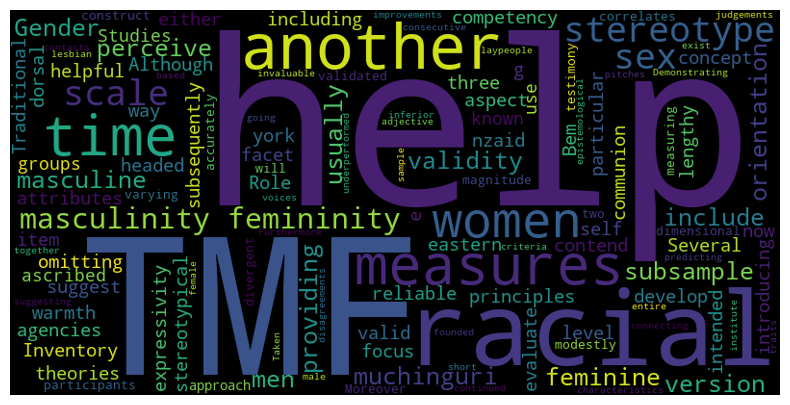

In [51]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

texte_réécrit = " ".join(find_kth_closest_word(mot) for mot in mots)

wordcloud = WordCloud(width=800, height=400, background_color='black').generate(texte_réécrit)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='catrom')
plt.axis('off')
plt.show()


[Projet Q2] Réécrire un texte donné en anglais en le genrifiant. Ainsi, chaque substantif et adjectif du texte devra être remplacé par le premier mot le plus proche dans le plongement lexical suivant la direction de genrification féminine. Il suffira alors d'utiliser les opérations d'analogie. Vous générerez le nuage de mots correspondant à partir du texte réécrit.

In [37]:
# Fonction pour trouver l'équivalent féminin d'un mot
def find_feminine_equivalent(word):
    try:
        # Trouver l'équivalent masculin du mot
        equivalent_masculin = wv.most_similar(positive=['homme', word], negative=['femme'])[0][0]

        # Trouver l'équivalent féminin du mot
        equivalent_féminin = wv.most_similar(positive=['femme', equivalent_masculin], negative=['homme'])[0][0]

        return equivalent_féminin
    except KeyError:
        return word

# Texte original
texte_original = """
Gender stereotype theory suggests that men are generally perceived as more masculine than women, whereas women are generally perceived as more feminine than men. Several scales have been developed to measure fundamental aspects of gender stereotypes (e.g., agency and communion, competence and warmth, or instrumentality and expressivity). Although omitted in later version, Bem's original Sex Role Inventory included the items “masculine” and “feminine” in addition to more specific gender-stereotypical attributes. We argue that it is useful to be able to measure these two core concepts in a reliable, valid, and parsimonious way. We introduce a new and brief scale, the Traditional Masculinity-Femininity (TMF) scale, designed to assess central facets of self-ascribed masculinity-femininity. Studies 1–2 used known-groups approaches (participants differing in gender and sexual orientation) to validate the scale and provide evidence of its convergent validity. As expected the TMF reliably measured a one-dimensional masculinity-femininity construct. Moreover, the TMF correlated moderately with other gender-related measures. Demonstrating incremental validity, the TMF predicted gender and sexual orientation in a superior way than established adjective-based measures. Furthermore, the TMF was connected to criterion characteristics, such as judgments as straight by laypersons for the whole sample, voice pitch characteristics for the female subsample, and contact to gay men for the male subsample, and outperformed other gender-related scales. Taken together, as long as gender differences continue to exist, we suggest that the TMF provides a valuable methodological addition for research into gender stereotypes.
"""

# Diviser le texte en mots
mots = texte_original.split()

# Afficher chaque mot avec son équivalent féminin (si existant)
for mot in mots:
    mot_féminin = find_feminine_equivalent(mot)
    if mot_féminin != mot:
        print(f"{mot} -> {mot_féminin}")
    else:
        print(mot)


Gender
stereotype
theory


suggests -> suggesting
that -> even
men -> troops
are -> those
generally -> comparatively
perceived -> obvious
as -> both
more
masculine
than
women,
whereas -> thus
women
are -> those
generally -> comparatively
perceived -> obvious
as -> both
more
feminine
than
men.
Several
scales -> fatale
have
been -> be
developed -> develop
to -> helps
measure -> enacted
fundamental -> principle
aspects -> concept
of
gender
stereotypes
(e.g.,
agency -> officials
and -> .
communion,
competence -> fatale
and -> .
warmth,
or
instrumentality -> fatale
and -> .
expressivity).
Although
omitted -> fatale
in -> .
later
version,
Bem's
original -> initially
Sex
Role
Inventory
included -> including
the -> that
items -> products
“masculine”
and -> .
“feminine”
in -> .
addition -> including
to -> helps
more
specific
gender-stereotypical
attributes.
We
argue
that -> even
it -> even
is -> still
useful
to -> helps
be
able -> impossible
to -> helps
measure -> enacted
these
two
core -> fundamental
concepts -> idea
in

In [38]:
# insérer votre code ici

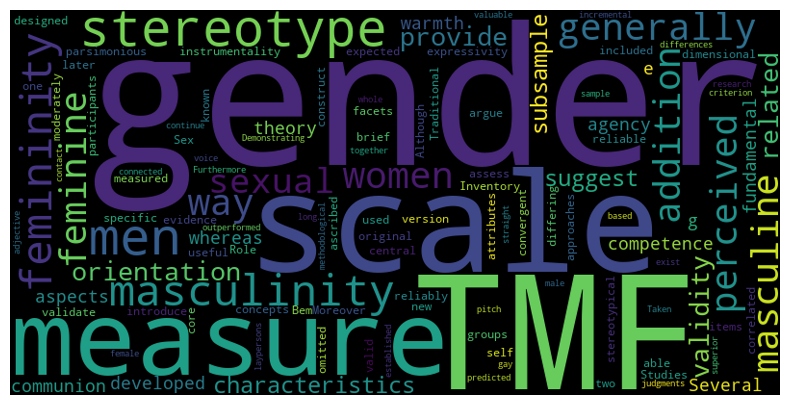

In [52]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

texte_réécrit = " ".join((mot) for mot in mots)

wordcloud = WordCloud(width=800, height=400, background_color='black').generate(texte_réécrit)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='catrom')
plt.axis('off')
plt.show()

In [40]:
# insérer votre code ici

5 - PROJET : Redéfinir l'algorithme Lesk
------

[Projet Q3] L'algorithme de Lesk (https://en.wikipedia.org/wiki/Lesk_algorithm) permet de désambiguiser le sens d'un mot dans un contexte défini. Ainsi il retourne le sens correspondant à un mot dans un contexte donné. La fonction OVERLAP implémentée dans l'algorithme Lesk permet de choisir le meilleur sens en fonction du cardinal de l'intersection des mots entre la définition du sens et le contexte textuel.

Ici, vous proposerez de faire cette sélection à partir d'une représentation sémantique continue des phrases. Chaque phrase devra être donc représentée par un vecteur sémantique. Vous pourrez utiliser le vecteur moyen de tous les mots dans une phrase (average pooling) ou des techniques plus abouties comme celle proposé par [(Hovy, 2025)](https://aclanthology.org/P15-1073.pdf). Le sens d'un mot dans son contexte sera donc celui qui maximise la similarité entre la représentation sémantique de la définition et celle du contexte.

In [41]:
import nltk
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
import numpy as np

# Télécharger WordNet si ce n'est pas déjà fait
# nltk.download('wordnet')
# nltk.download('punkt')

def get_definitions_from_wordnet(word):
    synsets = wn.synsets(word)
    definitions = [syn.definition() for syn in synsets]
    return definitions

def sentence_vector(sentence):
    tokens = word_tokenize(sentence)
    vecs = [wv[word] for word in tokens if word in wv]
    return np.mean(vecs, axis=0) if vecs else None

def lesk_algorithm(word, sentence):
    definitions = get_definitions_from_wordnet(word)
    if not definitions:
        return f"No definitions found for the word '{word}'"

    # Convertir la phrase en un vecteur sémantique
    sentence_vec = sentence_vector(sentence)
    if sentence_vec is None:
        return "Unable to generate a semantic vector for the given sentence."

    # Calculer la similarité entre la définition de chaque sens et la phrase
    similarities = [np.dot(sentence_vec, wv[definition.split()[0]]) for definition in definitions]

    # Trouver le sens avec la plus grande similarité
    best_index = np.argmax(similarities)
    return definitions[best_index]

# Exemple d'utilisation
word = "market"  # Exemple avec le mot "bank"
sentence = "I went to market to buy clothes."
result = lesk_algorithm(word, sentence)
print(f"Best sense for the word '{word}' in the context of '{sentence}':")
print(result)

Best sense for the word 'market' in the context of 'I went to market to buy clothes.':
buy household supplies


In [42]:
# insérer votre code ici

In [43]:
# insérer votre code ici

6 - PROJET MAISON  (A RENDRE UNE SEMAINE AVANT L'EXAMEN TERMINAL)
------

Vous devrez proposer une méthode originale de réécriture créative de texte dans la veine d\'OULIPO qui combine à la fois la ressource lexicale wordnet et les plongements lexicaux. Vous pourrez vous inspirer des nombreuses propostions [OULIPO](https://www.oulipo.net/). Vous pourrez bien entendu inclure tous les concepts abordés pendant les cours théoriques, comme par exemple les entités nommées et les unités polylexicales. Une mention spéciale vous sera accordée si vous travailer sur le Français ou toute autre langue que l'anglais. Dans ce cas, vous aurez besopin d'un moteur de traduction pour accéder aux définitions de wordnet. Vous trouverez des traducteurs [ICI](https://pypi.org/project/translators/). Pour les plongements lexicaux, vous aurez accès aux plongements multilingues de Fasttext [ICI](https://fasttext.cc/docs/en/crawl-vectors.html).

Bon courage et bonne créativité ;)

In [45]:
import nltk
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
from itertools import chain

# Télécharger les ressources de NLTK
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('maxent_ne_chunker')
#nltk.download('words')

# Une liste simple d'unités polylexicales pour la démonstration
polylexical_units = {
    'New York': 'NY',
    'United States': 'USA',
    
}

def find_synonyms(word):
    # Trouver les synonymes du mot en utilisant WordNet
    synonyms = {lemma.name().replace('_', ' ') for syn in wn.synsets(word) for lemma in syn.lemmas()}
    return list(synonyms)

def apply_oulipian_constraints(word, synonyms):
    # Appliquer une contrainte oulipienne, par exemple, choisir un synonyme aléatoire
    if synonyms:
        return random.choice(synonyms)
    return word

def extract_named_entities(ne_chunked):
    # Extraire les entités nommées à partir de la structure chunked de NLTK
    def extract(tree):
        return ' '.join([child[0] for child in tree]) if hasattr(tree, 'label') else tree[0]

    return [extract(ne) for ne in ne_chunked if hasattr(ne, 'label') and ne.label() in ['PERSON', 'ORGANIZATION', 'GPE', 'LOCATION']]

def is_part_of_polylexical_unit(token, pos_tags, index):
    # Vérifier les tokens avant et après pour voir s'ils forment une unité polylexicale
    for unit in polylexical_units.keys():
        unit_tokens = unit.split()
        if token in unit_tokens:
            # Trouver les indices des tokens dans l'unité
            unit_indices = range(index, index + len(unit_tokens))
            if all(pos_tags[i][0] == unit_tokens[i-index] for i in unit_indices if i < len(pos_tags)):
                return unit
    return None

def rewrite_text(text):
    # Tokenise le texte en phrases, puis en mots
    sentences = sent_tokenize(text)
    rewritten_text = []

    for sentence in sentences:
        tokens = word_tokenize(sentence)
        pos_tags = pos_tag(tokens)
        ne_chunked = ne_chunk(pos_tags)
        named_entities = extract_named_entities(ne_chunked)
        rewritten_tokens = []

        skip_indices = []
        for i, (token, pos) in enumerate(pos_tags):
            if i in skip_indices:
                continue

            # Vérifier si le token fait partie d'une unité polylexicale
            polylexical_unit = is_part_of_polylexical_unit(token, pos_tags, i)
            if polylexical_unit:
                # Remplacer l'unité polylexicale par son abréviation ou synonyme
                rewritten_tokens.append(polylexical_units[polylexical_unit])
                skip_indices.extend(range(i, i + len(polylexical_unit.split())))
                continue

            # Vérifier si le token est une entité nommée
            if token in named_entities:
                rewritten_tokens.append(token)
            else:
                # Trouver des synonymes pour le mot
                synonyms = find_synonyms(token.lower())
                # Appliquer des contraintes oulipiennes
                new_word = apply_oulipian_constraints(token.lower(), synonyms)
                rewritten_tokens.append(new_word)

        rewritten_sentence = " ".join(rewritten_tokens)
        rewritten_text.append(rewritten_sentence)

    return " ".join(rewritten_text)

# Texte original
original_text = "The President of the United States gave a speech in New York."

# Réécriture du texte
rewritten_text = rewrite_text(original_text)
print(rewritten_text)


the United States President of the USA return group A speech inwards NY .
